In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import xgboost

In [107]:
from matplotlib import pyplot as plt

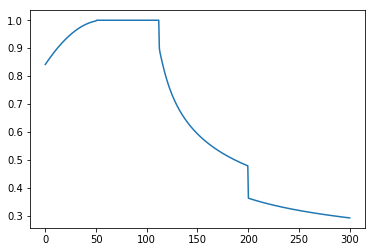

In [234]:
def punish(x):
    res = 1
    if x < 50:
        res = np.sin(x/100+1)
    if x > 112:
        res = np.log(x-109.5)/np.sqrt(x-111)
    if x > 200:
        res -= 10/x*np.log(x/20)
    return min(res,1)
dom = np.linspace(0,300,500)
plt.plot(dom,[f(x) for x in dom])

In [235]:
df = pd.read_csv('RealEstateData.csv',sep='\t')
def punish(x):
    res = 1
    if x < 50:
        res = np.sin(x/100+1)
    if x > 112:
        res = np.log(x-109.5)/np.sqrt(x-111)
    if x > 200:
        res -= 10/x*np.log(x/20)
    return min(res,1)
        
Punish = []
for index,row in df.iterrows():
    Punish.append(punish(row.DaysOnMarket))

# set month sold values
posted = df.DatePosted
sold = df.DateSold
seasonPosted = np.array([int(i[:2]) for i in list(posted)])
seasonSold = np.array([int(i[:2]) for i in list(sold)])
df['MonthPosted'] = seasonPosted
df['MonthSold'] = seasonSold
a=pd.get_dummies(df["MonthPosted"],drop_first=True,dtype='int64')
a=a.rename({2:"Posted_Feb",
            3:"Posted_Mar",
            4:"Posted_Apr",
            5:"Posted_May",
            6:"Posted_June",
            7:"Posted_July",
            8:"Posted_Aug",
            9:"Posted_Sept",
            10:"Posted_Oct",
            11:"Posted_Nov",
            12:"Posted_Dec"},axis=1)
b = pd.get_dummies(df['MonthSold'],drop_first=True,dtype=int)
b=b.rename({2:"Sold_Feb",
            3:"Sold_Mar",
            4:"Sold_Apr",
            5:"Sold_May",
            6:"Sold_June",
            7:"Sold_July",
            8:"Sold_Aug",
            9:"Sold_Sept",
            10:"Sold_Oct",
            11:"Sold_Nov",
            12:"Sold_Dec"},axis=1,)
df=df.join(a)
df=df.join(b)

df['Marketability'] = Punish

df.drop(["City","Zipcode","DateSold","MonthPosted","MonthSold",'DatePosted','DaysOnMarket'], axis=1, inplace=True)


In [238]:
target = df.Marketability
# OUR OVERALL TRAINING/TESTING SPLITS
X_train,X_test,y_train,y_test = tts(df,
                                    target,
                                    test_size=0.2,
                                    random_state=40)

# TARGETS FOR PREDICTING PRICE AND DAYS 
# yPrice = X_test.SoldPrice
# yDays = X_test.DaysOnMarket

# # Our data for the target values
# X_for_Days = X_train.drop(["DaysOnMarket",
#                            "Marketability"],axis=1)
# X_for_Price = X_train.drop(["SoldPrice",
#                             "DaysOnMarket",
#                             "Marketability"],axis=1)

# # Training/testing sets for finding DAYS
# XDays_train = X_train.drop(["DaysOnMarket",
#                             "Marketability"],axis=1)
# XDays_test = X_test.drop(["DaysOnMarket",
#                           "Marketability"],axis=1)
# yDays_train = X_train.DaysOnMarket
# yDays_test = X_test.DaysOnMarket

# Training/testing sets for finding PRICE
XPrice_train = X_train.drop(["SoldPrice"],axis=1)
XPrice_test = X_test.drop(["SoldPrice"],axis=1)
yPrice_train = X_train.SoldPrice
yPrice_test = X_test.SoldPrice

# Support Vector Machines

In [ ]:
%%time
# Gridsearch for SVMs, which didn't work properly...
pipe = Pipeline([('gbr',svm.SVR())])
param_grid = [{'gbr__kernel':['linear', 'poly', 'rbf', 'sigmoid','precomputed'],
               'gbr__gamma':np.arange(0.01,1,0.04),
               'gbr__shrinking':[True,False],
               'gbr__degree':np.arange(3,7,1),
               'gbr__coef0':np.arange(0,4,1),
               'gbr__epsilon':np.arange(0.01,0.11,0.02),
               'gbr__C':np.arange(0.1,3,0.5)}]
gs = GridSearchCV(pipe, 
                  param_grid, 
                  cv=3,
                  verbose=1,
                  n_jobs=-1)
gs.fit(XPrice_train,yPrice_train)
print(gs.best_params_,gs.best_score_)
print(gs.score(XPrice_test,yPrice_test))
print('-'*42)

In [239]:
%%time
model = svm.SVR(gamma='scale')
model.fit(XPrice_train,yPrice_train)
print(model.score(XPrice_test,yPrice_test))
print('-'*42)

0.2340037861847818
------------------------------------------
Wall time: 56 s


In [6]:
%%time
model = svm.SVR(gamma='scale')
model.fit(XDays_train,yDays_train)
print(model.score(XDays_test,yDays_test))
print('-'*42)

-0.05464235789724237
------------------------------------------
CPU times: user 1min 19s, sys: 491 ms, total: 1min 20s
Wall time: 1min 20s


# K-Nearest Neighbors Regression

In [ ]:
%%time
model = KNeighborsRegressor()
model.fit(XPrice_train,yPrice_train)
print(model.score(XPrice_test,yPrice_test))
print('-'*42)

-7.611381771289308
------------------------------------------
Wall time: 567 ms


In [8]:
%%time
model = KNeighborsRegressor()
model.fit(XDays_train,yDays_train)
print(model.score(XDays_test,yDays_test))
print('-'*42)

-0.10860765679199536
------------------------------------------
CPU times: user 521 ms, sys: 6.27 ms, total: 527 ms
Wall time: 527 ms


# Kernel Ridge Regressor

In [ ]:
%%time
model = KernelRidge()
model.fit(XPrice_train,yPrice_train)
print(model.score(XPrice_test,yPrice_test))
print('-'*42)

In [11]:
%%time
model = KernelRidge()
model.fit(XDays_train,yDays_train)
print(model.score(XDays_test,yDays_test))
print('-'*42)

0.07244139014823814
------------------------------------------
CPU times: user 7min 32s, sys: 1min 55s, total: 9min 28s
Wall time: 8min 16s


# Partial Least Squares Regression

In [ ]:
%%time
model = PLSRegression()
model.fit(XPrice_train,yPrice_train)
print(model.score(XPrice_test,yPrice_test))
print('-'*42)

In [14]:
%%time
model = PLSRegression()
model.fit(XDays_train,yDays_train)
print(model.score(XDays_test,yDays_test))
print('-'*42)

0.05878411507859349
------------------------------------------
CPU times: user 145 ms, sys: 35.5 ms, total: 180 ms
Wall time: 48 ms


# XGBoost Regression

In [ ]:
%%time
model = xgboost.XGBRegressor(learning_rate=0.2, 
                             gamma=0,
                             booster='dart',
                             n_estimators=200,
                             max_depth=6,
                             random_state=42,
                             reg_alpha=0,
                             reg_lambda=1.8)
model.fit(XPrice_train,yPrice_train)
print('Price accuracy score:',model.score(XPrice_test,yPrice_test))
print('-'*42)

In [ ]:
%%time
model = xgboost.XGBRegressor(learning_rate=0.2, 
                             gamma=0,
                             booster='dart',
                             n_estimators=200,
                             max_depth=6,
                             random_state=42,
                             reg_alpha=0,
                             reg_lambda=1.8)
model.fit(XDays_train,yDays_train)
print('Price accuracy score:',model.score(XDays_test,yDays_test))
print('-'*42)

# Gradient Boosting Trees Regressor

In [94]:
print('I printed all the information under this cell. Took 707 minutes.')
print('-'*42)
# GBT gridsearch. Definitely not re-running this again...
pipe = Pipeline([('gbr',GradientBoostingRegressor(n_estimators=500,max_depth=6))])
param_grid = [{'gbr__loss':['ls', 'lad', 'huber', 'quantile'],
               'gbr__learning_rate':np.arange(0.1,1.1,0.1),
               'gbr__alpha':np.linspace(0.1,0.99,8),
               'gbr__warm_start':[True,False]}]
gs = GridSearchCV(pipe, 
                  param_grid, 
                  cv=7,
                  verbose=1,
                  n_jobs=-1)
gs.fit(XPrice_train,yPrice_train)
print(gs.best_params_,gs.best_score_)
print(gs.score(XPrice_test,yPrice_test))
print("Most important features:\n")
print(XPrice_train.columns[model.feature_importances_>0.05])

I printed all the information under this cell. Took 707 minutes.
------------------------------------------
Fitting 7 folds for each of 640 candidates, totalling 4480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 67.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 121.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 192.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 279.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 384.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 504.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 642.1min
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed: 710.2min finished


{'gbr__alpha': 0.99, 'gbr__learning_rate': 0.30000000000000004, 'gbr__loss': 'huber', 'gbr__warm_start': False} 0.8128490906033462
0.8649449891310053
Most important features:

Index(['Bathrooms', 'HouseSize(sqft)', 'YearBuilt', 'DaysOnMarket',
       'Marketability'],
      dtype='object')


In [ ]:
%%time
# prev: {'gbr__alpha': 0.99, 'gbr__learning_rate': 0.30000000000000004, 'gbr__loss': 'huber', 'gbr__warm_start': False}
gs = GradientBoostingRegressor(n_estimators=1000,max_depth=6,alpha=0.99,learning_rate=0.4,loss='huber',warm_start=True)
gs.fit(XPrice_train,yPrice_train)
print(gs.score(XPrice_test,yPrice_test))
print('-'*42)

In [19]:
%%time
# prev: {'gbr__alpha': 0.99, 'gbr__learning_rate': 0.30000000000000004, 'gbr__loss': 'huber', 'gbr__warm_start': False}
gs = GradientBoostingRegressor(n_estimators=1000,max_depth=6,alpha=0.99,learning_rate=0.4,loss='huber',warm_start=True)
gs.fit(XDays_train,yDays_train)
print(gs.score(XDays_test,yDays_test))
print('-'*42)

0.2521325258369421
------------------------------------------
CPU times: user 1min 35s, sys: 528 ms, total: 1min 36s
Wall time: 1min 36s
